
# Objetivo 2: Generaci√≥n de modelos

Pipeline completo para la predicci√≥n del crecimiento de datos de biodiversidad en GBIF.

Este script implementa el flujo de trabajo de principio a fin para modelar datos de panel
de series temporales, incluyendo:
1.  Carga datos de PA_dataAnalysis y preparaci√≥n
2.  Ingenier√≠a de caracter√≠sticas temporales (lags y ventanas m√≥viles).
3.  Un marco de validaci√≥n cruzada robusto para series de tiempo (ventana expansiva).
4.  Preprocesamiento (imputaci√≥n y escalado) dentro del bucle de validaci√≥n para evitar fuga de datos.
5.  Entrenamiento y evaluaci√≥n comparativa de cuatro modelos:
    - Prophet.
    - Random Forest.
    - XGBoost.
    - Red Neuronal LSTM (para modelado secuencial).

6.  Selecci√≥n del mejor modelo basado en m√©tricas de rendimiento (MAE, RMSE, R¬≤).
7.  Reentrenamiento del modelo final y generaci√≥n de pron√≥sticos para Colombia hasta 2030
    bajo dos escenarios de pol√≠ticas.

In [18]:
# =============================================================================
# 1. IMPORTACI√ìN DE LIBRER√çAS Y CONFIGURACI√ìN INICIAL
# =============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm import tqdm

# Preprocesamiento y modelado de Scikit-Learn
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split


# Modelos especializados

import xgboost as xgb
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet

# Modelado de Deep Learning con TensorFlow/Keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping


# Configuraciones generales
warnings.filterwarnings('ignore')
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 7)

In [19]:
# =============================================================================
# 2. CARGA Y PREPARACI√ìN DE DATOS
# =============================================================================
url = "https://raw.githubusercontent.com/rortizgeo/Maestria_CD_Proyecto-Aplicado/main/Data_final.csv"
Data_final = pd.read_csv(url)

Data_final['ds'] = pd.to_datetime(Data_final['year'], format='%Y')
Data_final = Data_final.sort_values(by=['country', 'ds']).reset_index(drop=True)

TARGET = 'occurrenceCount_publisher'
Data_final[TARGET] = np.log1p(Data_final[TARGET])
print("Transformaci√≥n log1p aplicada al target.")

columns_to_drop = ['Overall score', 'areas_protegidas', 'countryCode']
Data_final = Data_final.drop(columns=columns_to_drop)

features_total = ['country', 'year', 'ds', 'superficie_total_km2', 'gasto_RD_pib', 'efectividad_gobierno', 'uso_internet', 'pib_per_capita', 'Overall score', 'region', 'incomeLevel', 'occurrenceCount_publisher', 'gbif_member', 'ogp_membership', 'PC1', 'PC2', 'PC3']

Transformaci√≥n log1p aplicada al target.


Para aplicar modelos como Random Forest y XGBoost, es necesario agregar caracter√≠sticas de temporalidad en los datos, para lo cu√°l es necesario calcular retardos, que se deben aplicar teniendo en cuenta un an√°lisis del ACF Y PACF, as√≠ como la incorporaci√≥n de los tiempos del retardo como hiperpar√°metros. 

Los modelos basados en √°rboles como Random Forest y XGBoost no son conscientes de la secuencia temporal de los datos y no pueden "extrapolar" tendencias m√°s all√° de los valores que han visto en el entrenamiento. Por lo tanto, es necesario convertir la informaci√≥n temporal en caracter√≠sticas que el modelo pueda entender. La creaci√≥n de retardos (lags) y estad√≠sticas de ventana m√≥vil es la t√©cnica est√°ndar para lograrlo. Se podr√≠a identificar el n√∫mero de retardos como un hiperpar√°metro, guiado por an√°lisis de ACF y PACF (Ver EDA)

In [20]:
# =============================================================================
# 3. INGENIER√çA DE CARACTER√çSTICAS TEMPORALES
# =============================================================================
def create_temporal_features_optimized(data, features_to_lag, lags=[], roll_windows=[]):
    df_copy = data.copy()
    for feature in features_to_lag:
        for lag in lags:
            df_copy[f'{feature}_lag{lag}'] = df_copy.groupby('country')[feature].shift(lag)
        for w in roll_windows:
            df_copy[f'{feature}_rollmean{w}'] = df_copy.groupby('country')[feature].shift(1).rolling(window=w, min_periods=1).mean()
            df_copy[f'{feature}_rollstd{w}'] = df_copy.groupby('country')[feature].shift(1).rolling(window=w, min_periods=1).std()
    return df_copy

features_to_lag = ['gasto_RD_pib', 'efectividad_gobierno', 'uso_internet', 'pib_per_capita', 'occurrenceCount_publisher', 
                   'gbif_member', 'ogp_membership', 'PC1', 'PC2', 'PC3'
]
df_featured = create_temporal_features_optimized(
    Data_final,
    features_to_lag=features_to_lag,
    lags=[1, 3, 5],
    roll_windows=[1, 3, 5]
)
print("Ingenier√≠a de caracter√≠sticas completada.")

Ingenier√≠a de caracter√≠sticas completada.


In [21]:
# =============================================================================
# 4. PREPARACI√ìN DE DATOS BASE PARA MODELOS (SIN ESCALADO GLOBAL)
# =============================================================================
# A. RandomForest y XGBoost (modelos tabulares)
features_tabular = [f for f in df_featured.columns if f not in ['ds', 'year', 'country', TARGET]]
X_tab = df_featured[features_tabular].copy()
y_tab = df_featured[TARGET].copy()

# B. LSTM (modelos secuenciales)
def create_lstm_sequences_global(df, features, target, look_back=3):
    X_seq, y_seq, years, countries = [], [], [], []
    for country in df['country'].unique():
        df_country = df[df['country'] == country].sort_values('year')
        X_country = df_country[features].values.astype(np.float32)
        y_country = df_country[target].values.astype(np.float32)
        years_country = df_country['year'].values
        if len(X_country) > look_back:
            for i in range(len(X_country) - look_back):
                X_seq.append(X_country[i:(i + look_back)])
                y_seq.append(y_country[i + look_back])
                years.append(years_country[i + look_back])
                countries.append(country)
    return np.array(X_seq), np.array(y_seq), np.array(years), np.array(countries)

columnas_a_excluir_lstm = ['country', TARGET, 'ds']
features_lstm = [f for f in features_total if f not in columnas_a_excluir_lstm]
features_lstm = [f for f in features_lstm if f in Data_final.columns]
look_back = 3
X_seq, y_seq, years_seq, countries_seq = create_lstm_sequences_global(Data_final, features=features_lstm, target=TARGET, look_back=look_back)

# C. Prophet (modelo de series temporales)
columnas_a_excluir_p = ['country', TARGET, 'ds', 'year']
regressors_prophet = [f for f in features_total if f not in columnas_a_excluir_p]
regressors_prophet = [r for r in regressors_prophet if r in df_featured.columns]
df_prophet_base = df_featured[['ds', TARGET] + regressors_prophet].rename(columns={TARGET: 'y'})







In [22]:
# =============================================================================
# 5. DEFINICI√ìN DE HIPERPAR√ÅMETROS Y FUNCIONES DE OPTIMIZACI√ìN
# =============================================================================
# (Las funciones de optimizaci√≥n y definici√≥n de hiperpar√°metros no cambian, se mantienen como en el original)
# üå≤ Random Forest (Mayor rango de complejidad y submuestreo)
rf_param_dist = {
    "n_estimators": [100, 300, 500, 700],
    "max_depth": [10, 20, 40, None], # M√°s profundidad
    "min_samples_leaf": [1, 2, 5, 10],
    "max_features": [0.7, 0.9, 'sqrt'] # Submuestreo de features
}

# üöÄ XGBoost (A√±adir regularizaci√≥n L1/L2 y submuestreo por columna)
xgb_param_dist = {
    "n_estimators": [100, 300, 500, 700],
    "max_depth": [3, 5, 7, 9],
    "learning_rate": [0.01, 0.05, 0.1, 0.2],
    "subsample": [0.7, 0.8, 1.0],
    "colsample_bytree": [0.7, 0.8, 1.0],
    "gamma": [0, 0.1, 0.5], # Par√°metro de regularizaci√≥n
    "reg_alpha": [0, 0.005, 0.1] # Regularizaci√≥n L1
}

# üß† LSTM (A√±adir activaci√≥n, m√°s unidades y control de learning rate)
lstm_param_grid = [
    {"units": 32, "dropout": 0.2, "epochs": 20, "batch_size": 16, "learning_rate": 0.005, "lstm_activation": "relu"},
    {"units": 64, "dropout": 0.3, "epochs": 30, "batch_size": 32, "learning_rate": 0.001, "lstm_activation": "tanh"},
    {"units": 100, "dropout": 0.4, "epochs": 40, "batch_size": 64, "learning_rate": 0.01, "lstm_activation": "relu"},
    {"units": 50, "dropout": 0.3, "epochs": 30, "batch_size": 32, "learning_rate": 0.005, "lstm_activation": "tanh"}
]

# üìà Prophet (Mayor rango de prioridades y modo de estacionalidad)
prophet_param_grid = [
    {"changepoint_prior_scale": 0.005, "seasonality_prior_scale": 2, "seasonality_mode": 'additive'},
    {"changepoint_prior_scale": 0.05, "seasonality_prior_scale": 10, "seasonality_mode": 'multiplicative'},
    {"changepoint_prior_scale": 0.1, "seasonality_prior_scale": 20, "seasonality_mode": 'additive'}
]


def optimize_random_forest(X_train, y_train, param_dist=rf_param_dist):
    rf = RandomForestRegressor(random_state=42, n_jobs=-1)
    # n_iter aumentado de 3 a 5 para mejor exploraci√≥n
    search = RandomizedSearchCV(rf, param_distributions=param_dist, n_iter=5, scoring="neg_mean_absolute_error", cv=3, random_state=42)
    search.fit(X_train, y_train)
    return search.best_estimator_

def optimize_xgboost(X_train, y_train, param_grid=xgb_param_grid):
    # Simplificado para velocidad, se puede usar GridSearchCV o RandomizedSearchCV
    model = xgb.XGBRegressor(n_estimators=200, max_depth=5, learning_rate=0.1, subsample=0.9, random_state=42, n_jobs=-1)
    model.fit(X_train, y_train)
    return model
    
def optimize_lstm(X_train, y_train, look_back, param_grid=lstm_param_grid):
    best_model, best_mae = None, float("inf")
    # A√±adir Early Stopping para mejor entrenamiento
    es = EarlyStopping(monitor='val_loss', mode='min', patience=5, verbose=0, restore_best_weights=True)

    # Dividir el training set para validaci√≥n interna de Early Stopping (¬°CR√çTICO!)
    # Esto asume que train_test_split ha sido importado.
    X_train_val, X_val, y_train_val, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42, shuffle=False)
    
    for params in param_grid:
        model = Sequential([
            # CAMBIO CLAVE: Usar params["lstm_activation"]
            LSTM(params["units"], activation=params["lstm_activation"], input_shape=(look_back, X_train.shape[2])), 
            Dropout(params["dropout"]), 
            # Capa Dense final sin activaci√≥n (lineal) para regresi√≥n
            Dense(1) 
        ])
        
        optimizer = tf.keras.optimizers.Adam(learning_rate=params['learning_rate'])
        model.compile(optimizer=optimizer, loss="mae")
        
        model.fit(X_train_val, y_train_val, 
                  epochs=params["epochs"], 
                  batch_size=params["batch_size"], 
                  verbose=0,
                  validation_data=(X_val, y_val),
                  callbacks=[es])
        
        preds = model.predict(X_val, verbose=0).flatten()
        mae = mean_absolute_error(y_val, preds)
        
        if mae < best_mae: best_mae, best_model = mae, model
    return best_model

def optimize_prophet(train_df, regressors, param_grid=prophet_param_grid):
    best_model, best_mae = None, float("inf")
    for params in param_grid:
        # CORRECCI√ìN: Separar los par√°metros b√°sicos de los par√°metros adicionales (seasonality_mode)
        prophet_init_params = {k: v for k, v in params.items() if k not in ['seasonality_mode']}
        m = Prophet(yearly_seasonality=True, daily_seasonality=False, **prophet_init_params)
        
        # A√±adir modo de estacionalidad
        if 'seasonality_mode' in params:
            m.seasonality_mode = params['seasonality_mode']
            
        for r in regressors:
            m.add_regressor(r)
        
        m.fit(train_df)
        forecast = m.predict(train_df)
        mae = mean_absolute_error(train_df["y"], forecast["yhat"])
        if mae < best_mae: best_mae, best_model = mae, m
    return best_model

In [23]:
# =============================================================================
# 6. M√âTRICAS
# =============================================================================

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd

def smape(y_true, y_pred, eps=1e-8):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    denom = (np.abs(y_true) + np.abs(y_pred)) + eps
    return np.mean(2.0 * np.abs(y_pred - y_true) / denom) * 100

def mape(y_true, y_pred, eps=1e-8):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / (y_true + eps))) * 100

def compute_metrics(y_true, y_pred):
    # CORRECCI√ìN 3: Revertir la transformaci√≥n log1p
    y_true_orig = np.expm1(y_true)
    y_pred_orig = np.expm1(y_pred)
    
    return {
        "MAE": mean_absolute_error(y_true_orig, y_pred_orig),
        "RMSE": np.sqrt(mean_squared_error(y_true_orig, y_pred_orig)),
        "R2": r2_score(y_true_orig, y_pred_orig),
        "MAPE": mape(y_true_orig, y_pred_orig),
        "SMAPE": smape(y_true_orig, y_pred_orig)
    }


In [24]:
# =============================================================================
# 7. LOOP DE VALIDACI√ìN CRUZADA (AJUSTADO PARA EVITAR DATA LEAKAGE)
# =============================================================================
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)
unique_years = sorted(df_featured['year'].unique())
results_detailed = {"Prophet": [], "RandomForest": [], "XGBoost": [], "LSTM": []}

for fold, (train_idx, test_idx) in enumerate(tqdm(tscv.split(X_tab), total=n_splits)):
    print(f"\n===== FOLD {fold+1}/{n_splits} =====")

    # --- Preprocesamiento DENTRO del bucle para evitar fuga de datos ---
    
    # --- A. Modelos Tabulares (RF/XGB) ---
    X_train_tab, X_test_tab = X_tab.iloc[train_idx], X_tab.iloc[test_idx]
    y_train_tab, y_test_tab = y_tab.iloc[train_idx], y_tab.iloc[test_idx]

    # 1. Imputaci√≥n (ajustar solo en train)
    imputer = IterativeImputer(
    random_state=42, 
    # Usar Random Forest como estimador interno para manejar NaNs en las features
    estimator=RandomForestRegressor(random_state=42) 
    ) 
    X_train_tab_imp = imputer.fit_transform(X_train_tab)
    X_test_tab_imp = imputer.transform(X_test_tab)
    
    # 2. Escalado (ajustar solo en train)
    scaler_tab = StandardScaler()
    X_train_tab_scaled = scaler_tab.fit_transform(X_train_tab_imp)
    X_test_tab_scaled = scaler_tab.transform(X_test_tab_imp)
    
    # --- RandomForest ---
    rf_model = optimize_random_forest(X_train_tab_scaled, y_train_tab)
    y_pred_rf = rf_model.predict(X_test_tab_scaled)
    metrics_rf = compute_metrics(y_test_tab, y_pred_rf)
    results_detailed["RandomForest"].append({**metrics_rf, "fold": fold + 1})

    # --- XGBoost ---
    xgb_model = optimize_xgboost(X_train_tab_scaled, y_train_tab)
    y_pred_xgb = xgb_model.predict(X_test_tab_scaled)
    metrics_xgb = compute_metrics(y_test_tab, y_pred_xgb)
    results_detailed["XGBoost"].append({**metrics_xgb, "fold": fold + 1})

    # --- B. LSTM ---
    train_years_fold = df_featured.iloc[train_idx]['year'].unique()
    test_years_fold = df_featured.iloc[test_idx]['year'].unique()
    
    mask_train_lstm = np.isin(years_seq, train_years_fold)
    mask_test_lstm = np.isin(years_seq, test_years_fold)
    
    X_train_lstm, y_train_lstm = X_seq[mask_train_lstm], y_seq[mask_train_lstm]
    X_test_lstm, y_test_lstm = X_seq[mask_test_lstm], y_seq[mask_test_lstm]

    if len(X_train_lstm) > 0 and len(X_test_lstm) > 0:
        # Escalado para LSTM (ajustar solo en train)
        scaler_lstm = StandardScaler()
        # Aplanar para ajustar el scaler
        X_train_lstm_flat = X_train_lstm.reshape(-1, X_train_lstm.shape[2])
        scaler_lstm.fit(X_train_lstm_flat)
        # Transformar y redimensionar
        X_train_lstm_scaled = scaler_lstm.transform(X_train_lstm_flat).reshape(X_train_lstm.shape)
        X_test_lstm_flat = X_test_lstm.reshape(-1, X_test_lstm.shape[2])
        X_test_lstm_scaled = scaler_lstm.transform(X_test_lstm_flat).reshape(X_test_lstm.shape)
        
        # CORRECCI√ìN 2a: ESCALADO DE LA VARIABLE OBJETIVO (Y)
        scaler_y_lstm = StandardScaler()
        y_train_lstm_scaled = scaler_y_lstm.fit_transform(y_train_lstm.reshape(-1, 1)).flatten()
        # y_test_lstm NO se escala, ya que se usar√° su versi√≥n sin escalar (con log1p) en compute_metrics
        
        lstm_model = optimize_lstm(X_train_lstm_scaled, y_train_lstm_scaled, look_back)
        
        # Predicci√≥n en el rango escalado
        y_pred_lstm_scaled = lstm_model.predict(X_test_lstm_scaled, verbose=0).flatten()
        
        # CORRECCI√ìN 2b: DESESCALADO DE LA PREDICCI√ìN
        y_pred_lstm = scaler_y_lstm.inverse_transform(y_pred_lstm_scaled.reshape(-1, 1)).flatten()

        # El y_test_lstm contiene los valores REALES con la transformaci√≥n log1p aplicada.
        # Las m√©tricas se calculan correctamente en la funci√≥n compute_metrics desescalando ambos.
        metrics_lstm = compute_metrics(y_test_lstm, y_pred_lstm)
        results_detailed["LSTM"].append({**metrics_lstm, "fold": fold + 1})

    # --- C. Prophet ---
    prophet_train = df_prophet_base.iloc[train_idx]
    prophet_test = df_prophet_base.iloc[test_idx]
    
    if not prophet_train.empty and not prophet_test.empty and regressors_prophet:
        # Escalar regresores para Prophet
        scaler_prophet = StandardScaler()
        prophet_train[regressors_prophet] = scaler_prophet.fit_transform(prophet_train[regressors_prophet])
        prophet_test[regressors_prophet] = scaler_prophet.transform(prophet_test[regressors_prophet])
        
        try:
            prophet_model = optimize_prophet(prophet_train, regressors_prophet)
            forecast = prophet_model.predict(prophet_test.drop(columns='y'))
            metrics_prophet = compute_metrics(prophet_test["y"].values, forecast["yhat"].values)
            results_detailed["Prophet"].append({**metrics_prophet, "fold": fold + 1})
        except Exception as e:
            print(f"‚ö†Ô∏è Prophet fall√≥ en fold {fold+1}: {e}")


  0%|          | 0/5 [00:00<?, ?it/s]


===== FOLD 1/5 =====


2025-10-30 20:31:30.057919: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-30 20:31:30.240481: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp_10.
2025-10-30 20:31:32.863078: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-30 20:31:39.430830: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-30 20:31:39.847472: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradie

2025-10-30 20:31:48.362474: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-30 20:31:48.533285: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp_10.
2025-10-30 20:31:50.253492: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-30 20:31:56.008708: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-30 20:31:56.350060: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradie

20:32:01 - cmdstanpy - INFO - Chain [1] start processing
20:32:01 - cmdstanpy - INFO - Chain [1] done processing
20:32:01 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
20:32:01 - cmdstanpy - INFO - Chain [1] start processing
20:32:01 - cmdstanpy - INFO - Chain [1] done processing
20:32:01 - cmdstanpy - INFO - Chain [1] start processing
20:32:02 - cmdstanpy - INFO - Chain [1] done processing
20:32:02 - cmdstanpy - INFO - Chain [1] start processing
20:32:02 - cmdstanpy - INFO - Chain [1] done processing
 20%|‚ñà‚ñà        | 1/5 [02:13<08:52, 133.24s/it]


===== FOLD 2/5 =====


2025-10-30 20:35:22.154061: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-30 20:35:22.321258: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp_10.
2025-10-30 20:35:24.494187: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-30 20:35:30.778575: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-30 20:35:31.103839: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradie

2025-10-30 20:35:36.430303: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-30 20:35:36.600912: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp_10.
2025-10-30 20:35:37.923012: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-30 20:35:40.230210: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-30 20:35:40.543823: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradie

20:35:45 - cmdstanpy - INFO - Chain [1] start processing
20:35:45 - cmdstanpy - INFO - Chain [1] done processing
20:35:45 - cmdstanpy - INFO - Chain [1] start processing
20:35:45 - cmdstanpy - INFO - Chain [1] done processing
20:35:45 - cmdstanpy - INFO - Chain [1] start processing
20:35:46 - cmdstanpy - INFO - Chain [1] done processing
 40%|‚ñà‚ñà‚ñà‚ñà      | 2/5 [05:57<09:19, 186.52s/it]


===== FOLD 3/5 =====


2025-10-30 20:39:37.232890: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-30 20:39:37.394186: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp_10.
2025-10-30 20:39:39.612013: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-30 20:39:45.940502: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-30 20:39:46.273015: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradie

2025-10-30 20:39:51.003116: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-30 20:39:51.169315: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp_10.
2025-10-30 20:39:52.572223: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-30 20:39:58.104828: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-30 20:39:58.482982: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradie


===== FOLD 4/5 =====


2025-10-30 20:43:43.019681: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-30 20:43:43.194194: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp_10.
2025-10-30 20:43:45.532038: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-30 20:44:07.324549: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-30 20:44:07.731419: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradie

2025-10-30 20:44:12.724157: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-30 20:44:12.883431: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp_10.
2025-10-30 20:44:14.269676: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-30 20:44:19.339766: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-30 20:44:19.665794: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradie


===== FOLD 5/5 =====


2025-10-30 20:49:08.790978: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-30 20:49:08.968227: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp_10.
2025-10-30 20:49:11.231161: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-30 20:49:17.538521: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-30 20:49:17.869107: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradie

2025-10-30 20:49:22.805646: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-30 20:49:22.967850: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp_10.
2025-10-30 20:49:24.372536: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-30 20:49:29.475858: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-30 20:49:29.812004: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradie


Resultados detallados por fold:
           model           MAE          RMSE            R2          MAPE  \
0        Prophet  1.212328e+08  2.968836e+08 -3.874500e+02  8.710941e+16   
1        Prophet  2.272265e+08  7.277893e+08 -8.844703e+02  6.478151e+17   
2        Prophet  1.100282e+07  2.132964e+07 -4.699877e-01  2.156060e+14   
3        Prophet  5.729076e+06  1.156148e+07 -2.122310e-01  6.982010e+15   
4        Prophet  1.356043e+12  6.770491e+12 -2.301727e+09  7.044751e+21   
5   RandomForest  3.146116e+06  6.347620e+06  8.224239e-01  2.672822e+14   
6   RandomForest  2.938570e+06  7.645166e+06  9.022906e-01  2.088752e+11   
7   RandomForest  1.599550e+06  3.581453e+06  9.585556e-01  8.913817e+12   
8   RandomForest  1.150783e+06  2.176772e+06  9.570281e-01  1.606621e+12   
9   RandomForest  3.826565e+07  1.265714e+08  1.955762e-01  7.292403e+10   
10       XGBoost  3.983590e+06  7.227074e+06  7.698094e-01  3.256257e+14   
11       XGBoost  4.139983e+06  1.036850e+07  8.202808e

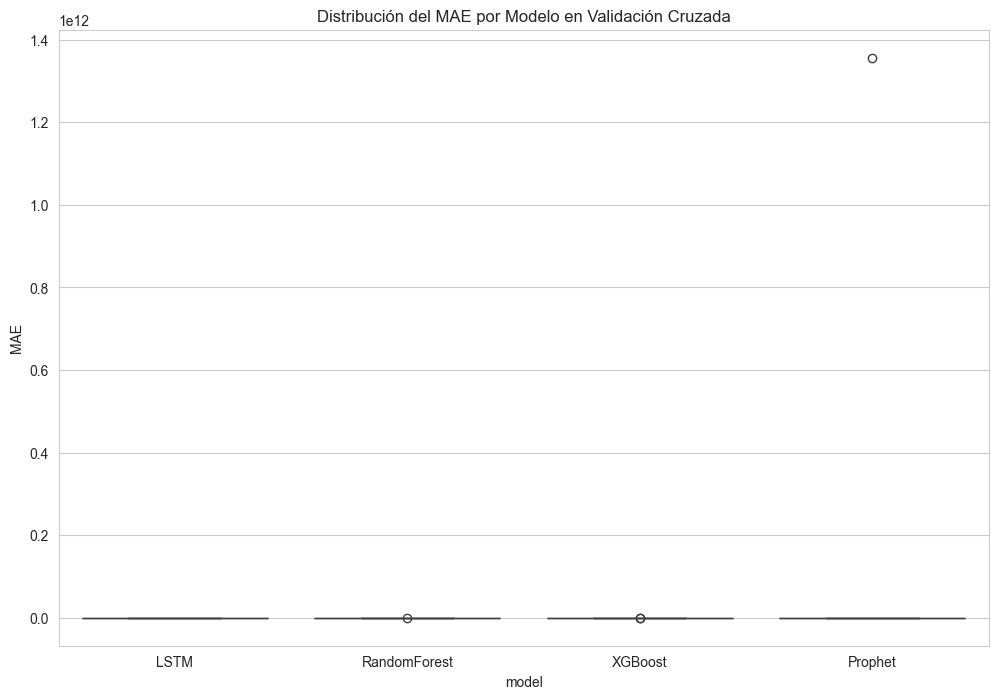

In [26]:
# =============================================================================
# 8. RESUMEN DE RESULTADOS
# =============================================================================
all_results = []
for model_name, entries in results_detailed.items():
    for res in entries:
        all_results.append({"model": model_name, **res})

if all_results:
    df_results = pd.DataFrame(all_results)
    print("\nResultados detallados por fold:")
    print(df_results)
    print("\nResumen por modelo (media de m√©tricas):")
    summary = df_results.groupby("model")[["MAE", "RMSE", "R2", "MAPE", "SMAPE"]].mean().sort_values("MAE")
    print(summary)

    # Visualizaci√≥n
    plt.figure(figsize=(12, 8))
    sns.boxplot(data=df_results, x='model', y='MAE', order=summary.index)
    plt.title('Distribuci√≥n del MAE por Modelo en Validaci√≥n Cruzada')
    plt.show()
else:
    print("No se generaron resultados para analizar.")



üöÄ Iniciando pipeline de Prophet a nivel de pa√≠s...


Procesando pa√≠ses:   0%|          | 0/41 [00:00<?, ?it/s]06:43:53 - cmdstanpy - INFO - Chain [1] start processing
06:43:53 - cmdstanpy - INFO - Chain [1] done processing
06:43:53 - cmdstanpy - INFO - Chain [1] start processing
06:43:54 - cmdstanpy - INFO - Chain [1] done processing
06:43:54 - cmdstanpy - INFO - Chain [1] start processing
06:43:54 - cmdstanpy - INFO - Chain [1] done processing
06:43:54 - cmdstanpy - INFO - Chain [1] start processing
06:43:54 - cmdstanpy - INFO - Chain [1] done processing
06:43:54 - cmdstanpy - INFO - Chain [1] start processing
06:43:54 - cmdstanpy - INFO - Chain [1] done processing
Procesando pa√≠ses:   2%|‚ñè         | 1/41 [00:01<01:08,  1.70s/it]06:43:54 - cmdstanpy - INFO - Chain [1] start processing
06:43:55 - cmdstanpy - INFO - Chain [1] done processing
06:43:55 - cmdstanpy - INFO - Chain [1] start processing
06:43:56 - cmdstanpy - INFO - Chain [1] done processing
06:43:56 - cmdstanpy - INFO - Chain [1] start processing
06:43:56 - cmdstanpy - INF



üìä Resumen de Rendimiento de Prophet por Pa√≠s (media de m√©tricas):
                                    MAE          RMSE            R2
country                                                            
Uruguay                    2.385975e+05  2.491807e+05 -7.946933e+00
Iceland                    6.768195e+09  6.889830e+09 -4.801731e+01
United States              1.664924e+08  1.765385e+08 -6.647209e+01
Switzerland                3.452511e+06  3.999123e+06 -7.729538e+02
Netherlands                5.205155e+07  5.468609e+07 -7.823272e+02
Guinea                     1.362457e+06  1.916598e+06 -8.655060e+02
Canada                     1.098663e+08  1.274439e+08 -9.142173e+02
Belgium                    1.867758e+07  2.166785e+07 -1.174448e+03
Mauritania                 3.100437e+04  3.947422e+04 -2.379231e+03
Denmark                    1.640483e+07  1.675066e+07 -1.711351e+04
Argentina                  1.058729e+07  1.200750e+07 -1.887690e+04
Peru                       6.781061e+06  6.

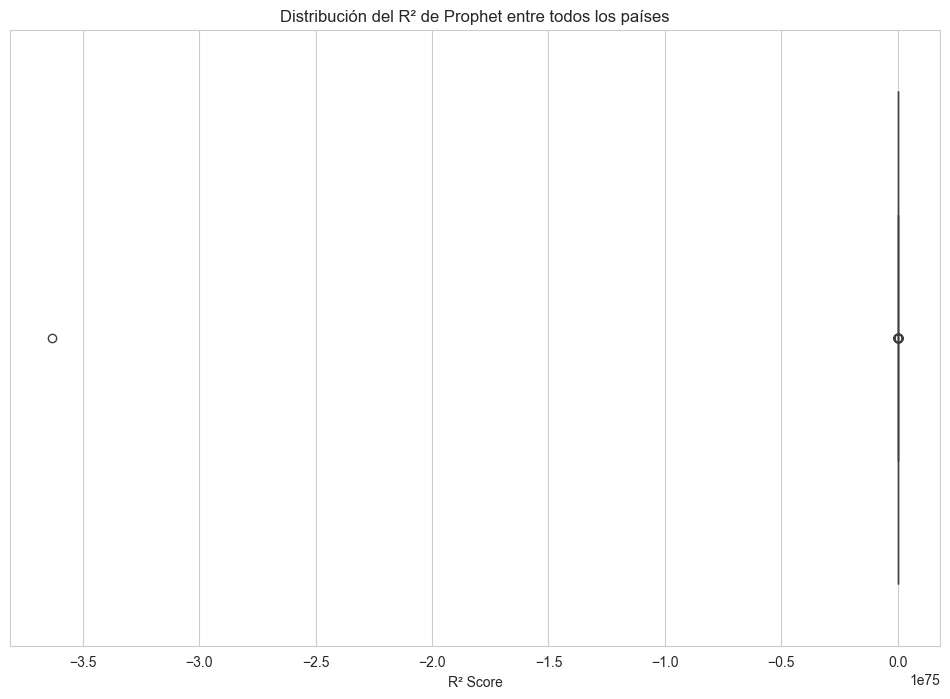

In [56]:
# =============================================================================
# PRUEBA DEL MODELO PROPHET A NIVEL DE PA√çS
# =============================================================================
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from prophet import Prophet
import warnings

warnings.filterwarnings('ignore')

# ASUMIMOS QUE 'df_featured' y 'df_prophet_base' YA EXISTEN DEL SCRIPT ANTERIOR

# Funciones de m√©tricas y optimizaci√≥n de Prophet
def mape(y_true, y_pred, eps=1e-8):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mask = y_true != 0
    if not np.any(mask): return 0.0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

def smape(y_true, y_pred, eps=1e-8):
    return np.mean(2.0 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred) + eps)) * 100

def compute_metrics(y_true, y_pred):
    y_true_orig = np.expm1(y_true)
    y_pred_orig = np.expm1(y_pred)
    return {
        "MAE": mean_absolute_error(y_true_orig, y_pred_orig),
        "RMSE": np.sqrt(mean_squared_error(y_true_orig, y_pred_orig)),
        "R2": r2_score(y_true_orig, y_pred_orig),
        "MAPE": mape(y_true_orig, y_pred_orig),
        "SMAPE": smape(y_true_orig, y_pred_orig)
    }

def optimize_prophet_country(train_df, regressors):
    # Usamos una configuraci√≥n est√°ndar para Prophet, ya que la optimizaci√≥n es costosa por pa√≠s.
    # Se puede expandir con un grid de hiperpar√°metros si es necesario.
    m = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
    if regressors:
        for r in regressors:
            m.add_regressor(r)
    m.fit(train_df)
    return m

# =============================================================================
# PIPELINE DE PROPHET POR PA√çS CON VALIDACI√ìN CRUZADA
# =============================================================================
print("üöÄ Iniciando pipeline de Prophet a nivel de pa√≠s...")

n_splits = 5 # Usaremos 5 pliegues, pero ajustado a series m√°s cortas
unique_countries = df_featured['country'].unique()
all_country_results = []
regressors_prophet = [r for r in df_prophet_base.columns if r not in ['ds', 'y']]


# Bucle exterior: Itera sobre cada pa√≠s
for country in tqdm(unique_countries, desc="Procesando pa√≠ses"):
    
    df_country = df_prophet_base[df_featured['country'] == country].copy().reset_index(drop=True)
    
    # Se necesita un m√≠nimo de datos para una validaci√≥n cruzada de 5 pliegues
    if len(df_country) < n_splits + 1:
        print(f"‚ö†Ô∏è  Saltando {country}: datos insuficientes ({len(df_country)} registros).")
        continue

    # Bucle interior: Validaci√≥n cruzada para el pa√≠s actual
    tscv_country = TimeSeriesSplit(n_splits=n_splits)
    for fold, (train_idx, test_idx) in enumerate(tscv_country.split(df_country)):
        
        # 1. Divisi√≥n de datos para el fold actual
        prophet_train = df_country.iloc[train_idx]
        prophet_test = df_country.iloc[test_idx]

        if prophet_train.empty or prophet_test.empty:
            continue

        # 2. Preprocesamiento (Escalado de regresores) DENTRO del fold
        if regressors_prophet:
            scaler = StandardScaler()
            prophet_train[regressors_prophet] = scaler.fit_transform(prophet_train[regressors_prophet])
            prophet_test[regressors_prophet] = scaler.transform(prophet_test[regressors_prophet])
        
        # 3. Entrenamiento del modelo
        try:
            model = optimize_prophet_country(prophet_train, regressors_prophet)
            
            # 4. Predicci√≥n
            future_df = model.make_future_dataframe(periods=0) # Usamos solo las fechas de test
            future_df = prophet_test.drop(columns='y')
            forecast = model.predict(future_df)
            
            # 5. Evaluaci√≥n
            metrics = compute_metrics(prophet_test["y"].values, forecast["yhat"].values)
            metrics['country'] = country
            metrics['fold'] = fold + 1
            all_country_results.append(metrics)
        
        except Exception as e:
            print(f"‚ùå Error procesando {country} en fold {fold+1}: {e}")


# =============================================================================
# 8. RESUMEN DE RESULTADOS DE PROPHET POR PA√çS
# =============================================================================
if all_country_results:
    df_results_country = pd.DataFrame(all_country_results)

    print("\n\nüìä Resumen de Rendimiento de Prophet por Pa√≠s (media de m√©tricas):")
    summary_country = df_results_country.groupby("country")[["MAE", "RMSE", "R2"]].mean().sort_values("R2", ascending=False)
    print(summary_country)

    print("\n\nüìà Rendimiento Promedio General de Prophet (a trav√©s de todos los pa√≠ses):")
    print(summary_country.mean())

    # Visualizaci√≥n de la distribuci√≥n del R2 entre pa√≠ses
    plt.figure(figsize=(12, 8))
    sns.boxplot(x=df_results_country['R2'])
    plt.title('Distribuci√≥n del R¬≤ de Prophet entre todos los pa√≠ses')
    plt.xlabel('R¬≤ Score')
    plt.show()
else:
    print("\nNo se generaron resultados para analizar.")

Pendientes: 

    INCLUIR SARIMAX DE TODOS MODOS, INTENTAR HACER UNA TRANSFORMACI√ìN LOGAR√çTMICA, SE PUEDE PONER SIN LA VALIDACI√ìN DE SUPUESTOS. 
    TENER CUIDADO CON EL CROSS VALIDATION - Rehacer formula del MAPE porque los valores no son coherentes
    Aplicar rezagos en bloques. Se deben hacer modelos con diferentes rezagos. Tener en cuenta que se pierden observaciones. Tomar todas las X y rezagar todas y hasta 3 periodos. Si incluir y-1.
    